## Done

- data engineering and analysis pipeline
    - get articles and edges based on category
    - add fields manually
    - build hyperlink network
    - build category network
    - calculate network attributes for both
    - calculate some descriptive statistics by field
    - estimate field dummies with network attributes
- visualizations:
    - degree distribution of hyperlink and category network
    - ratio of within-category edges by field
    - articles per field
    - correlation of field dummies
    - regression parameters of network attributes for field estimation
    - hyperlink network without edges
    - category network without labels

### To-do

#### Saturday
- clean data and balance categories
- reproduce all features and networks from clean data

#### Sunday
- perform degree-preserving randomization on network and compare attributes with original

#### Monday
- touch up figures

#### Tuesday
- write paper

--------------

### Jump to: <a id="contents"></a>

**Getting started**
- [import packages](#imp_pac)
- [intro to data](#intro)

*First time*
- [select categories](#select_cats)
- [import link and node data](#hyperlinks_nodes)

*Later*
- [import prepared data](#import_prep)

**Networks**
- [build hyperlink network](#build_graph)
- [build category network](#cat_network)
- [add features](#add_features)
- [degree distribution](#degree_dist)
- [pyvis visualization](#pyvis)
- [circular visualization](#circular)

**Analysing field-specific network phenomena**
- [field-specific network attributes](#field_spec)
    - [descriptive statistics](#descr_stats)
    - [predicting field with network attributes](#pred)

-------------------------

### import packages <a id="imp_pac">

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
from pyvis import network as net
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from statsmodels.api import Logit
from statsmodels.iolib.summary import Summary

from operator import or_
from functools import reduce
from itertools import combinations, repeat, chain

import glob

In [2]:
sns.set()

In [3]:
matplotlib.rcParams["figure.figsize"] = [12, 10]

------------

### intro to data <a id="intro">

[**back**](#contents)

**DATA SOURCE**:

[**Wikipedia hyperlinks**](https://snap.stanford.edu/data/wiki-topcats.html)

**ACADEMIC FIELDS**:

based on [**Wikipedia's own classification**](https://en.wikipedia.org/wiki/List_of_academic_fields)

**Formal sciences**
- computer science
- logic
- mathematics
- systems science

**Natural sciences**
- biology
- chemistry
- earth science
- physics
- space sciences

**Humanities and social science**
- anthropology
- history
- linguistics and languages
- philosophy
- religion
- arts
- economics
- geography
- interdisciplinary studies
- political science
- sociology
- psychology

------------

### select categories <a id="select_cats"></a>

[**back**](#contents)

In [175]:
with open("keywords.p", "rb") as fp:
    keywords = pickle.load(fp)

In [176]:
keywords

{'formal sciences': {'computer science': {'keywords': ['comput',
    'data',
    'informat',
    'algorithm',
    'programming'],
   'omit': ['graphics',
    'design',
    'film',
    'business',
    'companies',
    'law',
    'home',
    'personal',
    'games',
    'television']},
  'logic': {'omit': ['ologic']},
  'mathematics': {'keywords': ['mathematic']}},
 'natural sciences': {'biology': {'keywords': ['biolog'], 'omit': ['pest']},
  'chemistry': {'keywords': ['chemi']},
  'earth science': {'keywords': ['geo', 'paleo', 'meteo', 'tecto'],
   'omit': ['George',
    'Georgia',
    'geomet',
    'surgeon',
    'dungeon',
    'pigeon',
    'games',
    'engineer']},
  'physics': {'keywords': ['physic'], 'omit': ['physician', 'physical']},
  'space sciences': {'keywords': ['astro'],
   'omit': ['astrology', 'astronaut', 'gastro', 'player']}},
 'humanities and social science': {'anthropology': {'keywords': ['anthropolog']},
  'linguistics': {'keywords': ['linguist']},
  'philosophy': {

In [49]:
fields = pd.concat(
    [
        pd.DataFrame(
            [
                {"large_field": r.split("\n")[0], "field": field}
                for field in r.split("\n")[1:]
            ]
        )
        for r in open("fields.txt").read().strip().split("\n\n")
    ]
)

In [4]:
categories = {}

with open("wiki-topcats-categories.txt", "r") as fp:
    l = fp.readline().strip("\n").split(" ")
    while len(l) > 1:
        categories[l[0].split(":")[1].strip(";")] = set(l[1:])
        l = fp.readline().strip("\n").split(" ")

In [17]:
def contains(string, list_):

    for l in list_:
        if l.lower() in string.lower():
            return True

    return False

In [82]:
def catsearch(keywords, exclude=[]):

    return set(
        sum(
            [
                [
                    c
                    for c in categories
                    if keyword in c.lower() and not contains(c, exclude)
                ]
                for keyword in keywords
            ],
            [],
        )
    )

-----------------

In [ ]:
articles = 

In [53]:
fields["field"].apply(
    lambda field: pd.DataFrame(
        [{"field": field, "node": node} for node in catsearch(field)]
    )
)

0                 Empty DataFrame
Columns: []
Index: []
1         field                                     ...
2              field                                ...
3                 Empty DataFrame
Columns: []
Index: []
0          field                   node
0  biology  ...
1             field                            node
...
2                 Empty DataFrame
Columns: []
Index: []
3           field                          node
0   ...
4                 Empty DataFrame
Columns: []
Index: []
0               field                   node
0  anth...
1            field                               nod...
2                 Empty DataFrame
Columns: []
Index: []
3             field                     node
0  phil...
4           field                         node
0  re...
5        field                                      ...
6             field                                 ...
7            field                     node
0  geogr...
8                 Empty DataFrame
Columns: []
In

---------------

------------------

### import link and node data <a id="hyperlinks_nodes"></a>

[**back**](#contents)

In [ ]:
def find_link_edges(cats, label=str(datetime.now())):

    nodes = reduce(or_, [categories[cat] for cat in cats])
    edges = []

    with open("wiki-topcats.txt", "r") as fp:
        _bar = tqdm()
        l = fp.readline().strip("\n").split(" ")
        while len(l) > 1:
            if (l[0] in nodes) and (l[1] in nodes):
                edges.append([l[0], l[1]])
            l = fp.readline().strip("\n").split(" ")
            _bar.update()
            
    pd.DataFrame(edges).to_csv("data/{}_link_edges.csv".format(label))

    return nodes, edges

In [ ]:
def find_names(nodes):
    
    names = {}

    with open("wiki-topcats-page-names.txt", "r") as fp:
        _bar = tqdm()
        l = fp.readline().strip("\n").split(" ")
        while len(l) > 1:
            if l[0] in nodes:
                names[l[0]] = " ".join(l[1:])
            l = fp.readline().strip("\n").split(" ")
            _bar.update()
            
    return names 

In [ ]:
nodes, edges = find_link_edges(cat_df["category"].values, "all_branches")

In [ ]:
names = pd.DataFrame.from_dict(find_names(nodes), orient="index").rename(
    columns={0: "title"}
)

In [ ]:
node_df = (
    pd.concat(
        [
            pd.DataFrame(
                [
                    {"node": n, "category": c}
                    for c in cat_df["category"].values
                    if n in categories[c]
                ]
            )
            for n in nodes
        ]
    )
    .merge(names, how="left", left_on="node", right_index=True)
    .merge(cat_df, how="left", on="category")
)

In [ ]:
node_df.head(5)

--------------

### import prepared data <a id="import_prep">

[**back**](#contents)

In [ ]:
files = glob.glob("data/*.csv")

In [ ]:
files

In [ ]:
def get(nth):

    df = pd.read_csv(files[nth])
    if "Unnamed: 0" in df.columns:
        return df.drop("Unnamed: 0", axis=1)
    return df

In [ ]:
field_df = get(0).set_index("field").sort_values(by="p_in_field", ascending=False)

In [ ]:
cat_df = get(1)

In [ ]:
cat_vis_df = get(2)

In [ ]:
cat_edges = get(3)

In [ ]:
edges = get(4).values.astype(str)

In [ ]:
filtered = get(5).assign(node=lambda df: df["node"].astype(str))

In [4]:
raw = get(6).assign(node=lambda df: df["node"].astype(str))

----------

### build hyperlink network <a id="build_graph"></a>

[**back**](#contents)

In [117]:
def graph(nodes, edges):

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    print(nx.info(G))

    if nx.is_connected(G):
        print("---------------------------\nGraph is connected")
    else:
        print("---------------------------\nGraph is not connected")

    return G

In [118]:
G_link = graph(filtered["node"].unique(), edges)

Name: 
Type: Graph
Number of nodes: 18192
Number of edges: 106574
Average degree:  11.7166
---------------------------
Graph is not connected


In [119]:
def largest(graph):

    largest = graph.subgraph(max(nx.connected_components(graph), key=len))
    print(nx.info(largest))

    return largest

In [120]:
L_link = largest(G_link)

Name: 
Type: Graph
Number of nodes: 18077
Number of edges: 106499
Average degree:  11.7828


In [126]:
pd.DataFrame(list(L_link.edges())).to_csv("data/all_branches_largest_edges.csv")

In [ ]:
filtered = node_df.loc[node_df["node"].isin(list(L_link.nodes()))]

In [ ]:
filtered.head(5)

-------------------

### build category network <a id="cat_network"></a>

[**back**](#contents)

In [36]:
G_cat = nx.Graph()

In [ ]:
cat_dict = node_df.groupby("category").apply(lambda df: set(df["node"])).to_dict()

In [ ]:
cat_edges = []

In [ ]:
for (c1, n1), (c2, n2) in combinations(cat_dict.items(), 2):
    w = len(n1 & n2)
    if w:
        cat_edges.append([c1, c2, w])

In [38]:
G_cat.add_weighted_edges_from(cat_edges.drop("color", axis=1).values)

In [39]:
print(nx.info(G_cat))

Name: 
Type: Graph
Number of nodes: 118
Number of edges: 1096
Average degree:  18.5763


In [40]:
nx.is_connected(G_cat)

True

In [ ]:
pd.DataFrame(cat_edges).rename(columns={0: "edge_1", 1: "edge_2", 2: "weight"}).to_csv(
    "data/all_branches_category_edges.csv"
)

----------

### add features <a id="add_features"></a>

[**back**](#contents)

##### add degrees, neighbor connectivity, clustering

In [ ]:
def neighbor_connectivity(node, graph):
    return np.array([graph.degree(n) for n in list(graph.neighbors(node))]).mean()

In [ ]:
def clustering(node, graph):
    
    return nx.clustering(graph, node)

In [ ]:
raw = (
    filtered.drop(["category", "field"], axis=1)
    .drop_duplicates()
    .reset_index(drop=True)
    .assign(
        degree=lambda df: df["node"].apply(lambda n: L_link.degree(n)),
        neighbor_conn=lambda df: df["node"].apply(neighbor_connectivity, graph=L_link),
        clustering=lambda df: df["node"].apply(clustering, graph=L_link),
    )
)

In [ ]:
cat_df = (
    cat_df.assign(degree=cat_df["category"].apply(lambda c: G_cat.degree(c)))
    .loc[lambda df: df["degree"].apply(lambda x: type(x) == int)]
    .assign(
        neighbor_conn=lambda df: df["category"].apply(
            neighbor_connectivity, graph=G_cat
        ),
        clustering=lambda df: df["category"].apply(clustering, graph=G_cat),
    )
)

In [ ]:
cat_df.to_csv("data/all_branches_category_df.csv")

##### add within and cross-category edges

In [ ]:
raw["within_field_degree"] = raw.apply(
    lambda r: len(
        set(L_link.neighbors(r["node"]))
        & set(
            filtered.loc[
                filtered["field"].isin(
                    set(filtered.loc[filtered["node"] == r["node"], "field"].values)
                ),
                "node",
            ].values
        )
    ),
    axis=1,
)

In [ ]:
raw["cross_field_degree"] = raw["degree"] - raw["within_field_degree"]

In [ ]:
raw["within_field_ratio"] = raw["within_field_degree"] / raw["degree"]

##### add number of categories and merge

In [ ]:
filtered = filtered.merge(
    pd.DataFrame(filtered.groupby("node").count()["category"])
    .reset_index()
    .rename(columns={"category": "number_of_cats"}),
    how="left",
    on="node",
).merge(raw.drop("title", axis=1), how="left", on="node")

In [ ]:
filtered.head(5)

In [ ]:
filtered.to_csv("data/all_branches_filtered.csv")

-------------

### degree distribution <a id="degree_dist"></a>

[**back**](#contents)

In [ ]:
def degree_dist(degrees_list, title="Degree distribution", labels=["Degree"]):

    colors = ["#0d1667", "#6dc9c8"]

    low = np.log10(max(1, min([degrees.min() for degrees in degrees_list])))
    high = max([np.log10(degrees.max()) for degrees in degrees_list])
    x = np.logspace(low, high)

    for idx, degrees in enumerate(degrees_list):
        plt.scatter(
            x[1:],
            pd.cut(degrees, bins=x).value_counts(normalize=True),
            c=colors[idx],
            label=labels[idx],
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1, (10 ** (int(high) + 1)))
    plt.ylim(10 ** (-5), 1)
    plt.xlabel("k")
    plt.ylabel("p(k)")
    plt.title(title)
    plt.legend()

In [ ]:
degree_dist([raw["degree"]], "Hyperlink degree distribution")

In [ ]:
degree_dist([cat_df["degree"]], "Category degree distribution")

In [ ]:
degree_dist(
    [raw["within_field_degree"], raw["cross_field_degree"]],
    "Within and cross-field degree distribution",
    ["Within field degree", "Cross field degree"],
)

-------------

### field-specific network attributes <a id="field_spec"></a>

[**back**](#contents)

##### descriptive statistics <a id="descr_stats">

In [ ]:
field_df = (
    filtered.groupby("field")
    .apply(
        lambda df: pd.Series(
            {
                "n_nodes": df["node"].unique().shape[0],
                "d_in_field": df.groupby("node")["within_field_degree"].max().sum(),
                "d_all": df.groupby("node")["degree"].max().sum(),
            }
        )
    )
    .assign(p_in_field=lambda df: df["d_in_field"] / df["d_all"])
).sort_values(by="p_in_field", ascending=False)

In [266]:
field_df.to_csv("data/all_branches_field_df.csv")

Text(0.5, 1.0, 'Ratio of within-field edges by field')

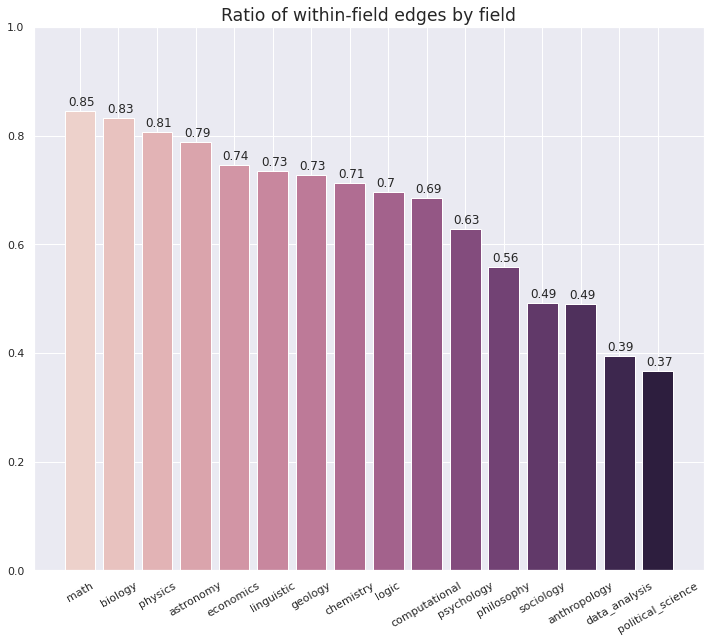

In [252]:
plt.bar(
    field_df.index,
    field_df["p_in_field"].values,
    color=sns.cubehelix_palette(field_df.shape[0]),
)

plt.xticks(rotation=30)
plt.ylim(0, 1)

for idx, r in enumerate(field_df["p_in_field"]):
    plt.text(x=idx - 0.3, y=r + 0.01, s=round(r, 2), size=12)
    
plt.title("Ratio of within-field edges by field", fontsize="x-large")

Text(0.5, 1.0, 'Number of articles by field')

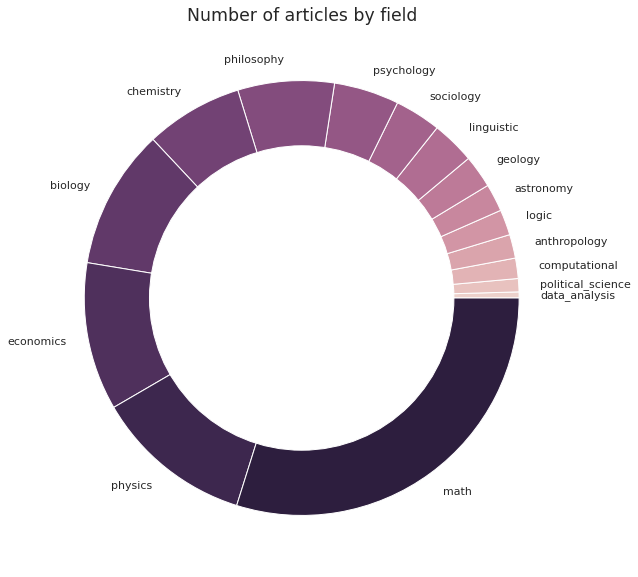

In [251]:
plt.pie(
    field_df["n_nodes"].sort_values().values,
    labels=field_df["n_nodes"].sort_values().index,
    colors=sns.cubehelix_palette(field_df.shape[0])    
)

plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.7, color="white"))
plt.title("Number of articles by field", fontsize="x-large")

In [ ]:
raw = raw.merge(
    filtered.groupby("node")
    .apply(
        lambda df: pd.DataFrame(
            {f: int(f in set(df["field"].values)) for f in field_df.index}, index=[0]
        )
    )
    .reset_index()
    .assign(node=lambda df: df["node"].astype(str).values)
    .drop("level_1", axis=1),
    how="outer",
    on="node",
)

In [ ]:
raw.to_csv("data/all_branches_field_dummies.csv")

Text(0.5, 1.0, 'Correlation matrix of field dummies')

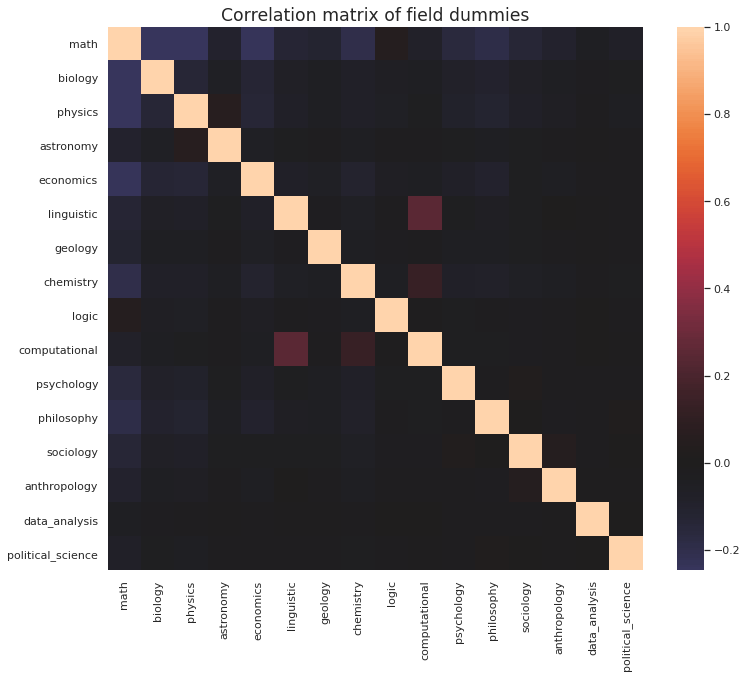

In [250]:
sns.heatmap(raw[field_df.index].corr(), center=0)
plt.title("Correlation matrix of field dummies", fontsize="x-large")

##### predicting field with network attributes <a id="pred">

[**back**](#contents)

In [192]:
def logit_model(dep, indep):

    X = (
        raw[indep]
        .pipe(
            lambda df: pd.DataFrame(
                StandardScaler().fit_transform(df), columns=df.columns, index=df.index
            )
        )
        .assign(const=1)
    )

    logit = Logit(raw[dep], X).fit()

    return pd.DataFrame([logit.params.rename("coeffs"), logit.pvalues.rename("p")])

In [ ]:
all_results = pd.concat(
    [
        logit_model(
            field,
            [
                "number_of_cats",
                "degree",
                "clustering",
                "neighbor_conn",
                "within_field_ratio",
            ],
        ).assign(field=field)
        for field in field_df.index
    ]
)

In [245]:
field_coeff_matrix = (
    all_results.groupby("field")
    .apply(
        lambda df: df.loc["coeffs"]
        * (0.01 > df.loc["p"]).astype(int).replace(0, np.nan)
    )
    .drop("const", axis=1)
)

Text(0.5, 1.0, 'Regression parameters by field and variable')

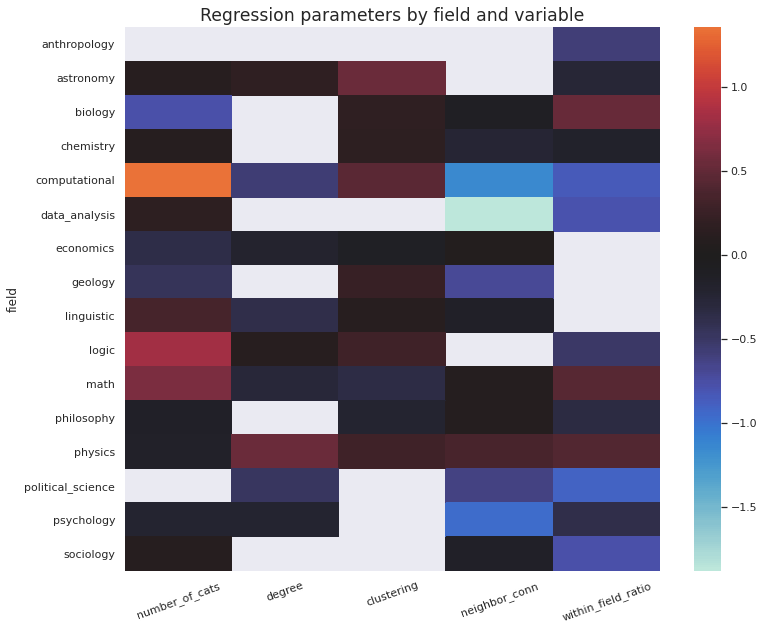

In [248]:
sns.heatmap(field_coeff_matrix, center=0)
plt.xticks(rotation=20)
plt.title("Regression parameters by field and variable", fontsize="x-large")

--------

### pyvis visualization <a id="pyvis"></a>

[**back**](#contents)

In [24]:
colors = pd.DataFrame.from_dict(
    {
        "philosophy": "#5BB9D6",
        "math": "#0E2F44",
        "logic": "#C6E2FF",
        "computational": "#aaaaaa",
        "data_analysis": "#6dc9c8",
        "physics": "#590d82",
        "biology": "#6ab861",
        "chemistry": "#e54f85",
        "astronomy": "#000000",
        "geology": "#32573d",
        "economics": "#523450",
        "sociology": "#FD765D",
        "linguistic": "#ffdb00",
        "psychology": "#cacbf9",
        "political_science": "#ff975f",
        "anthropology": "#72db93",
    },
    orient="index",
).rename(columns={0: "color"})

In [299]:
G_cat_pyvis = net.Network(
    notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="blue",
)

In [300]:
for idx, r in cat_df.iterrows():
    if r["category"] not in G_cat_pyvis.nodes:
        G_cat_pyvis.add_node(
            r["category"],
            mass=r["degree"] ** 2 / 10,
            size=r["degree"] ** 2 / 50,
            color=colors.loc[r["field"], "color"],
        )

In [305]:
for edge in cat_edges.values:
    G_cat_pyvis.add_edge(edge[0], edge[1], weight=edge[2], value=edge[2])

In [306]:
G_cat_pyvis.show("data/G_cat_pyvis.html")

--------------

### circular visualization <a id="circular"></a>

[**back**](#contents)

$(x-u)^2+(y-v)^2=r^2$

$y= ^+_- \sqrt{r^2-(x-u)^2} + v$

In [79]:
def circle(r, n, center=(0, 0)):

    x_values = (
        np.linspace(-r, r, n // 2 + 1)
        if (n % 2 == 0)
        else np.linspace(-r, r, n // 2 + 2)
    )

    return (
        [[x + center[0], np.sqrt(r ** 2 - x ** 2) + center[1]] for x in x_values[:-1]]
        + [
            [x + center[0], -np.sqrt(r ** 2 - x ** 2) + center[1]]
            for x in x_values[::-1][:-1]
        ]
    )[:n]

In [80]:
field_df["centers"] = circle(100, field_df.shape[0])

In [86]:
field_df["n_categories"] = cat_df.groupby("field").apply(
    lambda df: df["category"].unique().shape[0]
)

In [87]:
field_df["positions"] = field_df.apply(
    lambda r: circle(r["n_categories"], r["n_categories"], center=r["centers"]), axis=1
)

In [88]:
field_df.to_csv("data/all_branches_field_df.csv")

In [91]:
cat_vis_df = pd.concat(
    [
        _fdf.drop_duplicates("category")
        .sort_values("degree")
        .assign(position=field_df.loc[_fid, "positions"])
        .loc[:, ["category", "position", "degree", "field"]]
        for _fid, _fdf in cat_df.groupby("field")
    ]
).merge(colors, how="left", left_on="field", right_index=True)

In [93]:
cat_vis_df.to_csv("data/all_branches_category_vis_df.csv")

In [29]:
cat_df = cat_df.merge(colors, how="left", left_on="field", right_index=True)

In [34]:
cat_edges = (
    cat_edges.merge(
        cat_df[["category", "color"]], how="left", left_on="edge_1", right_on="category"
    )
    .drop("category", axis=1)
    .drop_duplicates(["edge_1", "edge_2"])
)

In [104]:
cat_edges.to_csv("data/all_branches_category_edges.csv")

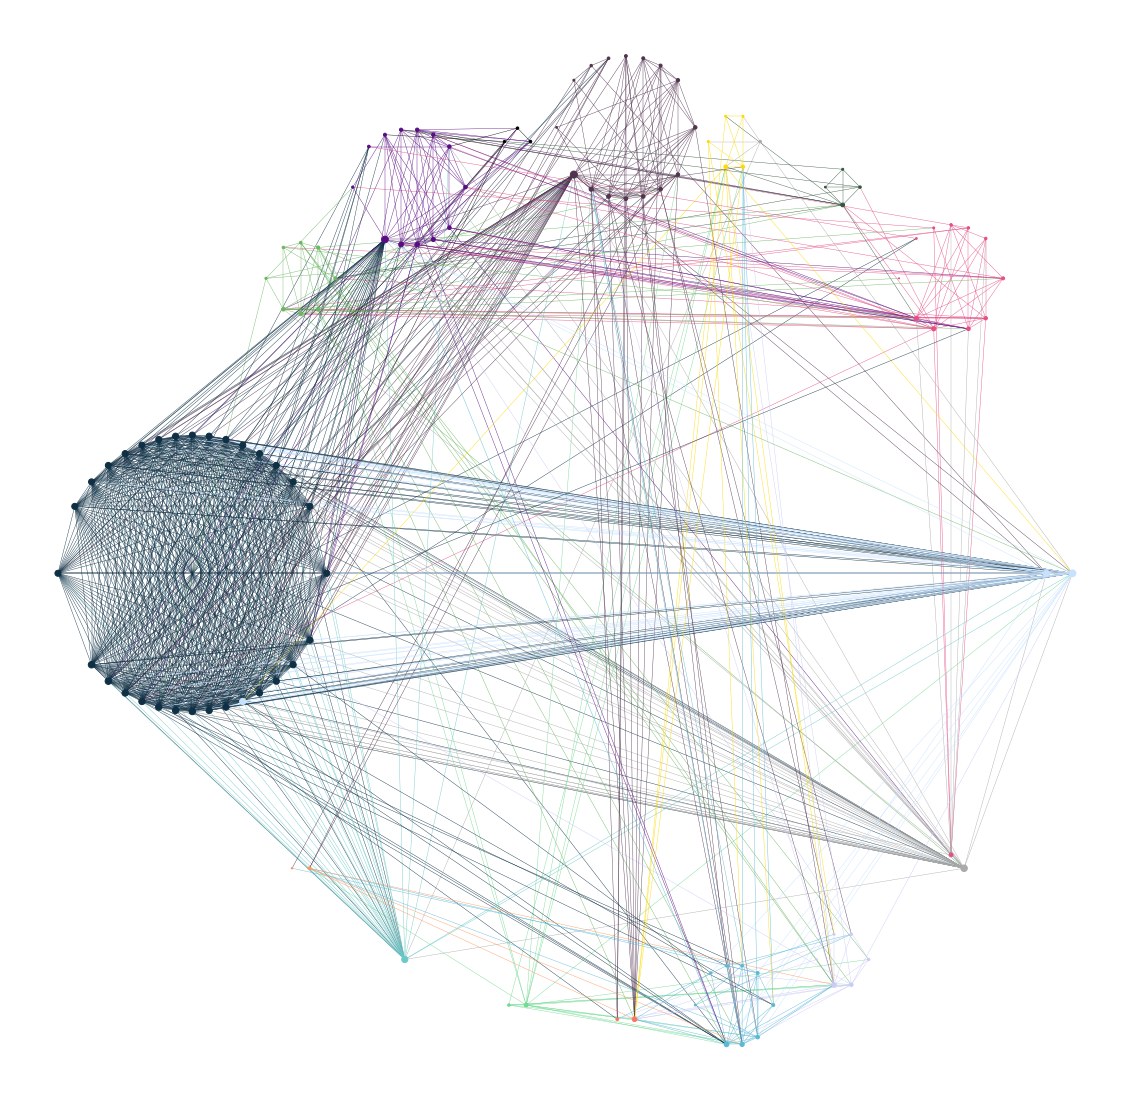

In [108]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.axis("off")
fig.set_facecolor("#FFFFFF")

nx.draw_networkx_nodes(
    G_cat,
    cat_vis_df.set_index("category")["position"].to_dict(),
    ax=ax,
    nodelist=cat_vis_df["category"].unique(),
    node_size=cat_vis_df.drop_duplicates("category")["degree"].values,
    node_color=cat_vis_df.drop_duplicates("category")["color"].values,
)

nx.draw_networkx_edges(
    G_cat,
    cat_vis_df.set_index("category")["position"].to_dict(),
    edgelist=cat_edges[["edge_1", "edge_2"]].values.tolist(),
    edge_color=cat_edges["color"].values,
    arrows=False,
    alpha=1,
    width=0.4,
)

---------